# SailGP Steering input lag

In this notebook we aim to determine the time between an input is entered on steering wheel and the boat reaction to it:

imports

In [105]:
import pandas as pd
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import os

### Reading the data

The data is the 10Hz logs downloaded from the database

In [66]:
path = r'Boat_Logs\2023-05-07\AUS\log_AUS_2023-05-07_10Hz.csv'

data = pd.read_csv(path)

To reduce the study we reduce the dataset to the first race of the data

In [67]:
data.TRK_RACE_NUM_unk.unique()

array([23050704., 23050705., 23050706.])

In [68]:
race_data = data[data.TRK_RACE_NUM_unk == 23050704]
race_data = race_data[race_data.TRK_BOAT_RACE_STATUS_unk == 2]

<Axes: xlabel='LONGITUDE_GPS_unk'>

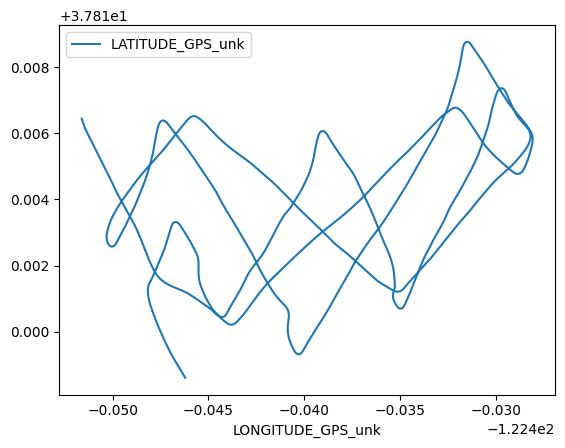

In [69]:
race_data.plot(x='LONGITUDE_GPS_unk', y='LATITUDE_GPS_unk')

A quick look at the data:

<Axes: >

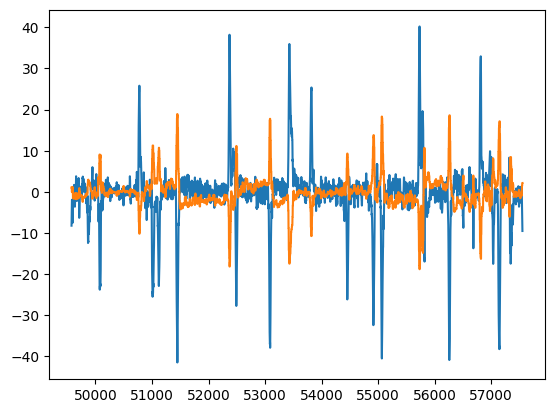

In [70]:
race_data.RATE_YAW_deg_s_1.plot()
race_data.ANGLE_RUDDER_deg.plot()

We inverse the Yaw rate as we can clearly see an opposite sign convention above.

In [94]:
sig1 = race_data.ANGLE_RUDDER_deg.reset_index(drop=True)
sig2 = -race_data.RATE_YAW_deg_s_1.reset_index(drop=True)
corr = scipy.signal.correlate(sig1, sig2, 'full')
lags = scipy.signal.correlation_lags(len(sig1), len(sig2), 'full')
corr /= np.max(corr)

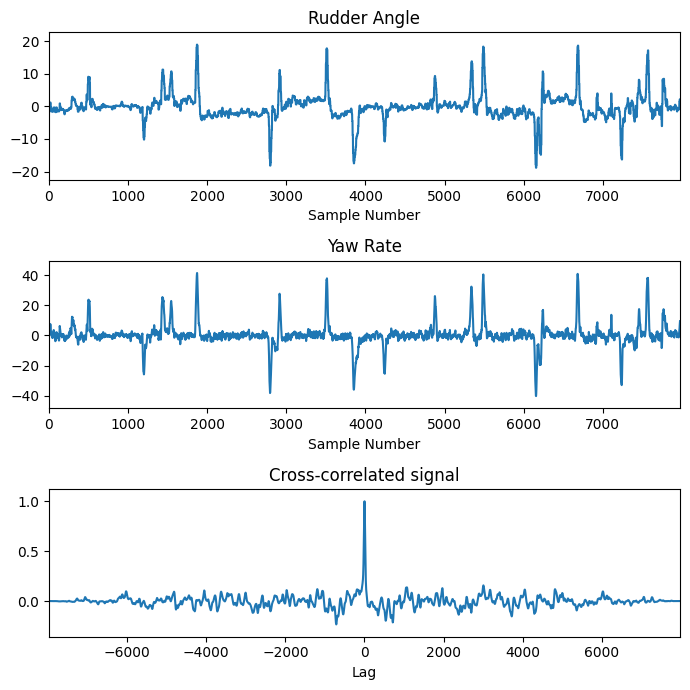

In [95]:
fig, (ax_orig, ax_noise, ax_corr) = plt.subplots(3, 1, figsize=(7, 7))
ax_orig.plot(sig1)
ax_orig.set_title('Rudder Angle')
ax_orig.set_xlabel('Sample Number')
ax_noise.plot(sig2)
ax_noise.set_title('Yaw Rate')
ax_noise.set_xlabel('Sample Number')
ax_corr.plot(lags, corr)
ax_corr.set_title('Cross-correlated signal')
ax_corr.set_xlabel('Lag')
ax_orig.margins(0, 0.1)
ax_noise.margins(0, 0.1)
ax_corr.margins(0, 0.1)
fig.tight_layout()
plt.show()

In [97]:
# Lag value with best correlation:
lags[np.argmax(corr)]

1

## Function to apply on other datasets:

In [98]:
def steering_to_yaw_lag(data):
    sig1 = data.ANGLE_RUDDER_deg.reset_index(drop=True)
    sig2 = -data.RATE_YAW_deg_s_1.reset_index(drop=True)
    corr = scipy.signal.correlate(sig1, sig2, 'full')
    lags = scipy.signal.correlation_lags(len(sig1), len(sig2), 'full')
    corr /= np.max(corr)
    lag = lags[np.argmax(corr)]
    return lag

## Testing on another race:

In [103]:
for race in [23050705, 23050706]:
    temp = data[data.TRK_RACE_NUM_unk == race]
    temp = race_data[race_data.TRK_BOAT_RACE_STATUS_unk == 2]
    print(steering_to_yaw_lag(temp))

1
1


Testing with other boats:

In [107]:
logs_folder = r'Boat_Logs\2023-05-07'
logs = {}
for boat in os.listdir(logs_folder):
    log_path = rf'Boat_Logs\2023-05-07\{boat}\log_{boat}_2023-05-07_10Hz.csv'
    logs[boat] = pd.read_csv(log_path)



In [116]:
for boat, b_data in logs.items():
    races = b_data.TRK_RACE_NUM_unk.unique()
    for race in races:

        # taking out the test races:
        race_number = int(str(int(race))[-2:])

        if race_number >10:
            continue

        temp = b_data[b_data.TRK_RACE_NUM_unk == race]
        temp = temp[temp.TRK_BOAT_RACE_STATUS_unk == 2]

        if temp.empty:
            continue

        lag = steering_to_yaw_lag(temp)

        print(f'LAG for {boat}, race {race} : {lag}')


LAG for AUS, race 23050704.0 : 1
LAG for AUS, race 23050705.0 : 0
LAG for AUS, race 23050706.0 : 1
LAG for CAN, race 23050704.0 : 0
LAG for CAN, race 23050705.0 : 0
LAG for DEN, race 23050704.0 : 1
LAG for DEN, race 23050705.0 : 0
LAG for ESP, race 23050704.0 : 1
LAG for ESP, race 23050705.0 : 0
LAG for FRA, race 23050704.0 : 0
LAG for FRA, race 23050705.0 : 0
LAG for GBR, race 23050704.0 : 0
LAG for GBR, race 23050705.0 : 0
LAG for GBR, race 23050706.0 : 0
LAG for NZL, race 23050704.0 : 0
LAG for NZL, race 23050705.0 : 0
LAG for NZL, race 23050706.0 : 0
LAG for SUI, race 23050704.0 : 1
LAG for SUI, race 23050705.0 : 0
LAG for USA, race 23050704.0 : 0
LAG for USA, race 23050705.0 : 1


### Conclusion
The lag between steering input and the yaw rate is lower than the resolution of the 10Hz log. So it is expected to be between 0 and 0.1s.